# Tutorial 2: 10x Visium (DLPFC dataset)

stGCL integrates gene expression profiles, spatial information and histological profiles (if accessible) as input, and then further learns low-dimensional latent representations by multi-modal graph contrastive learning. In this tutorial, we demonstrate how to identify spatial domains on 10x Visium data using stGCL. As a example, we analyse the slice 151674 of the DLPFC dataset. According to cytoarchitecture and gene markers, Maynard et al. has manually annotated neuronal layers (Layer 1-Layer 6) and white matter (WM). The processed data were downloaded from https://github.com/LieberInstitute/spatialLIBD and provided at https://zenodo.org/record/8137326/files/DLPFC.rar?download=1.

## Preparation

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import os
import torch
from sklearn.metrics.cluster import adjusted_rand_score
import time
import stGCL as stGCL
from stGCL.process import prefilter_genes,prefilter_specialgenes,set_seed,refine_nearest_labels
os.environ['R_HOME'] = '/home/dell/anaconda3/envs/stjupyter/lib/R'
from stGCL import utils,train_model

In [2]:
section_id="151674"
use_image=True
radius=50
seed=0
set_seed(seed)

In [3]:
input_dir = os.path.join('/home/dell/stproject/stGCL/Data/DLPFC/', section_id)
adata = sc.read_visium(path=input_dir, count_file=section_id + '_filtered_feature_bc_matrix.h5')
Ann_df = pd.read_csv(os.path.join('/home/dell/stproject/stGCL/Data/DLPFC/',
      section_id, "cluster_labels_" + section_id + '.csv'), sep=',', header=0,index_col=0)
adata.obs['ground_truth'] =  Ann_df.loc[adata.obs_names, 'ground_truth']
rad_cutoff =150
load=False
radius = 50
k=7
top_genes = 3000
# For 10x data, the number of training epochs is related to the number of spots. 
# We recommend using 1200 epochs for datasets with more than 3600 spots, 
# and 1000 epochs for datasets with fewer than 3600 spots.
epoch=(adata.n_obs > 3600 and 1200 or 1000)
im_re = pd.read_csv(os.path.join('/home/dell/stproject/stGCL/Data/DLPFC/',
              section_id, "image_representation/ViT_pca_representation.csv"), header=0, index_col=0, sep=',')

In [4]:
adata.var_names_make_unique()
prefilter_genes(adata, min_cells=3)  # avoiding all genes are zeros
prefilter_specialgenes(adata)
#Normalization
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=top_genes)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.scale(adata, zero_center=False, max_value=10)
adata.obsm["im_re"] = im_re

## Constructing the spatial network and Running model

In [5]:
utils.Cal_Spatial_Net(adata, rad_cutoff=rad_cutoff)

In [6]:
adata = train_model.train(adata,k,n_epochs=epoch,use_image=use_image,device=torch.device('cpu'))

train with image
Epoch:100 loss:0.85287
Epoch:200 loss:0.82151
Epoch:300 loss:0.81164
Epoch:400 loss:0.80757
Epoch:500 loss:0.80402
Epoch:600 loss:0.81374
Epoch:700 loss:0.80074
Epoch:800 loss:0.80023
Epoch:900 loss:0.79797
Epoch:1000 loss:0.79634
Epoch:1100 loss:0.79533
Epoch:1200 loss:0.79461


In [7]:
adata = utils.mclust_R(adata, used_obsm='stGCL', num_cluster=k)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 5.4.10
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


## Kuhn-Munkres algorithm for matching labels

In [8]:
obs_df = adata.obs.dropna()
obs_df['stGCL'] = utils.munkres_newlabel(obs_df['ground_truth']-1, obs_df['mclust'].astype('float32')-1)

Counter(new_predict)
 Counter({2.0: 885, 4.0: 643, 5.0: 603, 6.0: 571, 1.0: 503, 0.0: 324, 3.0: 106})
Counter(y_true)
 Counter({2.0: 924, 6.0: 625, 4.0: 621, 5.0: 614, 0.0: 380, 3.0: 247, 1.0: 224})


In [9]:
adata.obs['stGCL']=obs_df['stGCL'] +1
nearest_new_type =refine_nearest_labels(adata, radius, key='stGCL')
adata.obs['stGCL_refined'] = nearest_new_type
adata.obs['stGCL_refined'] =adata.obs['stGCL_refined'].astype('float32')

In [10]:
num_to_layer = {
    1: "Layer 1",
    2: "Layer 2",
    3: "Layer 3",
    4: "Layer 4",
    5: "Layer 5",
    6: "Layer 6",
    7: "WM",
}
adata.obs['ground_truth'] = adata.obs['ground_truth'].map(num_to_layer).astype('category')
adata.obs['stGCL_refined'] = adata.obs['stGCL_refined'].map(num_to_layer).astype('category')
adata.obs['stGCL'] = adata.obs['stGCL'].map(num_to_layer).astype('category')

In [11]:
obs_df = adata.obs.dropna()
ARI = adjusted_rand_score(obs_df['stGCL_refined'], obs_df['ground_truth'])
print('Adjusted rand index = %.5f' %ARI)

Adjusted rand index = 0.68885


In [12]:
spatial = pd.read_csv("/home/dell/stproject/stGCL/Data/DLPFC/{}/spatial/tissue_positions_list.csv".format(section_id),
                      sep=",", header=None,na_filter=False, index_col=0)
adata.obs["x_pixel"] = spatial[4]
adata.obs["y_pixel"] = spatial[5]

Text(0, 0.5, 'y_pixel')

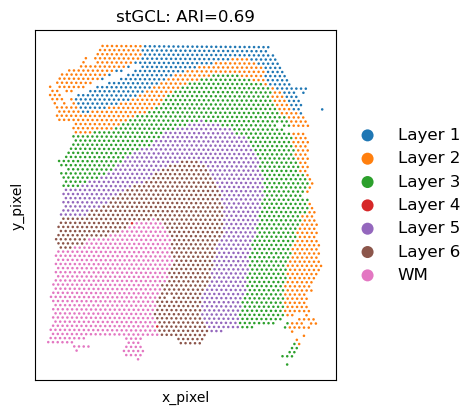

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
title = "stGCL: ARI={:.2}".format(ARI)
ax = sc.pl.scatter(adata, alpha=1, x="y_pixel", y="x_pixel", color="stGCL_refined",  legend_fontsize=12, show=False,title=title,
                       size=50000 / adata.shape[0])
ax.set_aspect('equal', 'box')
ax.set_xticks([])
ax.set_yticks([])
ax.axes.invert_yaxis()
plt.xlabel('x_pixel')
plt.ylabel('y_pixel')